Attempt 2 to predict cell type.

Data -> https://www.kaggle.com/datasets/paultimothymooney/blood-cells/code?resource=download-directory

In [4]:
# Import libraries
import numpy as np
# import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

In [14]:
# Dir path
train_dir = './archive/dataset2-master/dataset2-master/images/TRAIN'
test_dir = './archive/dataset2-master/dataset2-master/images/TEST'

In [19]:
# Some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

It is good practice to use a validation split in the development of the model. Let's use 80% of the images for training and 20% for validation.

In [23]:
# Train data
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [24]:
# Validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


In [25]:
# What are the names of the cell types?
class_names = train_ds.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


Visualising the data

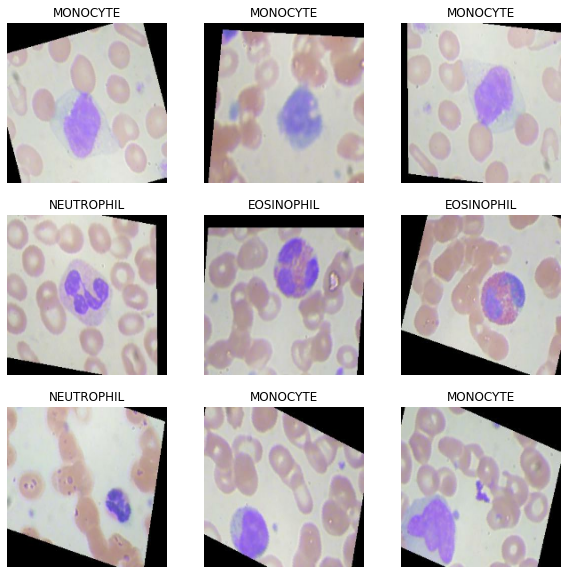

In [26]:
# Let's have a look at the first images of the training set.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
# It will train a model using these datasets by passing them to Model.fit. 
# model.fit -> Trains the model for a fixed number of epochs (iterations on a dataset).

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Configuring the dataset for performance

cache -> It keeps the images in memory after they are loaded out of the disk during the first epoch. This will ensure that the dataset does not become a bottleneck while training your model. If your dataset is too large to fit in memory, you can also use this method to create a high-performance on-disk cache.

prefetch -> Overlaps pre-processing and model execution during training.

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardise data

In [36]:
# Normalization

# To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalization_layer


In [38]:
# This transformation applies map_func to each element of this dataset, and returns a new dataset containing the transformed elements, 
# in the same order as they appeared in the input. 
# map_func can be used to change both the values and the structure of a dataset's elements

# lambda -> A lambda function is a small anonymous function.

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Notice the pixel values are now in [0,1].
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99760354


A Sequential model is appropriate for a flat stack of layers, where each layer has exactly one input tensor and one output tensor.
The sequential model consists of three convolution blocks ( tf.keras.layers.Conv2D ) with a maximum grouping layer ( tf.keras.layers.MaxPooling2D ) in each of them. There is a fully connected layer ( tf.keras.layers.Dense ) with 128 units on top that is activated by a ReLU activation function ( 'relu' ). 

tf.keras.layers.Conv2D -> 2D convolution layer (e.g. spatial convolution over images).

tf.keras.layers.MaxPooling2D -> Max pooling operation for 2D spatial data.

tf.keras.layers.Dense -> Just your regular densely-connected NN layer.

Create the model

In [41]:
# Number of different type of cells
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Compile the model

In [44]:
# Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# The method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, 
# and is well suited for problems that are large in terms of data/parameters"

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])